In [1]:
import torch

print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

2.7.0+cu128
GPU Available: True


In [2]:
from torch import nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torchvision
from torchvision import transforms

data_path = '/teamspace/studios/data-studio/data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

mnist_dataset = torchvision.datasets.MNIST(root=data_path, train=True, transform=transform, download=False)

batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

In [4]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [5]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [6]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 3e-4)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 2e-4)

In [7]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [8]:
mode_z:str
def d_train(x):
    disc_model.zero_grad()

    # train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)

    d_proba_fake = disc_model(g_output)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize only D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [9]:
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [10]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []
num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 4.8797/0.0922
Epoch 002 | Avg Losses >> G/D 4.7650/0.1315
Epoch 003 | Avg Losses >> G/D 4.0432/0.2310
Epoch 004 | Avg Losses >> G/D 3.2589/0.3034
Epoch 005 | Avg Losses >> G/D 2.9351/0.3309
Epoch 006 | Avg Losses >> G/D 2.8974/0.3142
Epoch 007 | Avg Losses >> G/D 2.9661/0.3093
Epoch 008 | Avg Losses >> G/D 2.9322/0.3172
Epoch 009 | Avg Losses >> G/D 2.8941/0.3095
Epoch 010 | Avg Losses >> G/D 2.9727/0.2871
Epoch 011 | Avg Losses >> G/D 3.0335/0.2855
Epoch 012 | Avg Losses >> G/D 3.0961/0.2693
Epoch 013 | Avg Losses >> G/D 3.1985/0.2519
Epoch 014 | Avg Losses >> G/D 3.2600/0.2516
Epoch 015 | Avg Losses >> G/D 3.3634/0.2394
Epoch 016 | Avg Losses >> G/D 3.3779/0.2183
Epoch 017 | Avg Losses >> G/D 3.4318/0.2223
Epoch 018 | Avg Losses >> G/D 3.5621/0.2197
Epoch 019 | Avg Losses >> G/D 3.5309/0.2158
Epoch 020 | Avg Losses >> G/D 3.5968/0.1841
Epoch 021 | Avg Losses >> G/D 3.5785/0.2107
Epoch 022 | Avg Losses >> G/D 3.6053/0.2203
Epoch 023 | Avg Losses >> G/D 3.

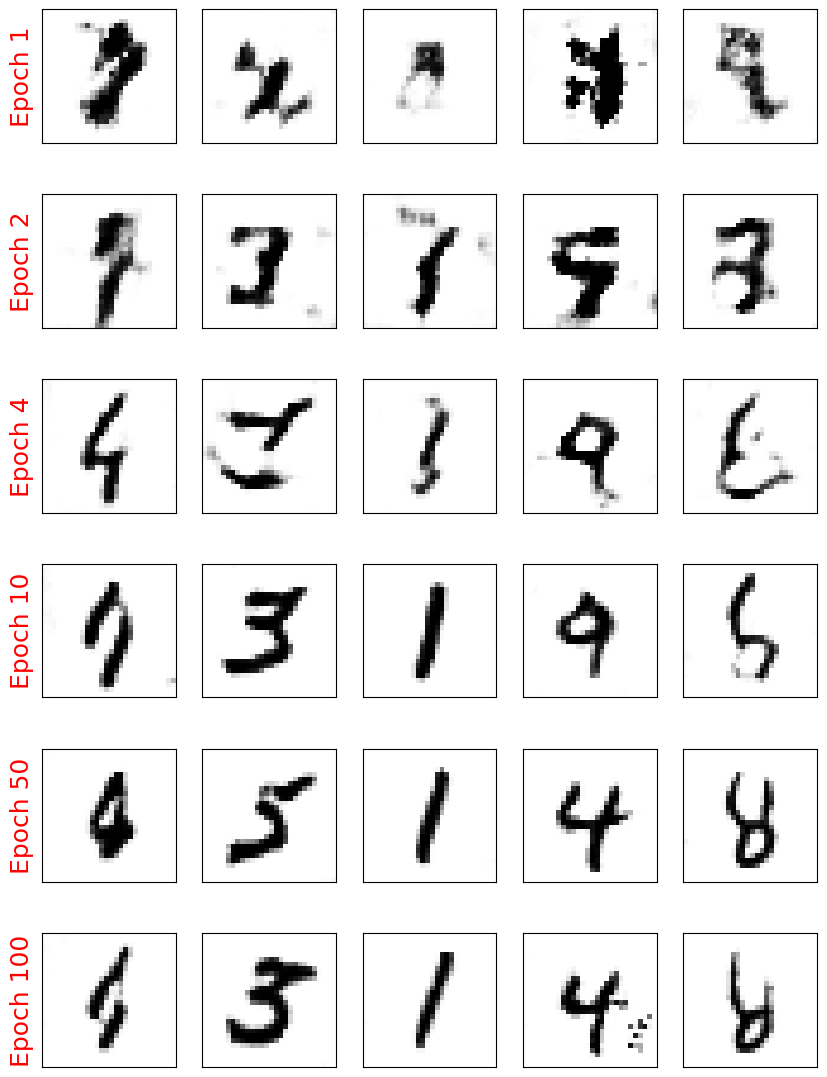

In [11]:
selected_epochs = [1, 2, 4, 10, 50, 100]
# selected_epochs = [1, 2, 3, 4, 5]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()

In [12]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [13]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(), 2e-4)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 2e-4)

In [14]:
from torch.autograd import grad as torch_grad

lambda_gp:float

def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data

    # calculate probability of interpolated examples
    proba_interpolated = disc_model(interpolated)

    # calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1)**2).mean()

In [15]:
def d_train_wgan(x):
    disc_model.zero_grad()
    batch_size = x.size(0)
    x = x.to(device)

    # calculate probabilities on real and generated data
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item()

In [16]:
def g_train_wgan(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    # gradient backprop & optimize only G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [17]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 100
torch.manual_seed(1)
critic_iterations = 5

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))

    print(f'Epoch {epoch:03d} | D Loss >>'
          f' {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | D Loss >> -0.2690
Epoch 002 | D Loss >> -0.5364
Epoch 003 | D Loss >> -0.6136
Epoch 004 | D Loss >> -0.6417
Epoch 005 | D Loss >> -0.6651
Epoch 006 | D Loss >> -0.6636
Epoch 007 | D Loss >> -0.6141
Epoch 008 | D Loss >> -0.5649
Epoch 009 | D Loss >> -0.5454
Epoch 010 | D Loss >> -0.5242
Epoch 011 | D Loss >> -0.5096
Epoch 012 | D Loss >> -0.4901
Epoch 013 | D Loss >> -0.4825
Epoch 014 | D Loss >> -0.4697
Epoch 015 | D Loss >> -0.4620
Epoch 016 | D Loss >> -0.4583
Epoch 017 | D Loss >> -0.4580
Epoch 018 | D Loss >> -0.4526
Epoch 019 | D Loss >> -0.4489
Epoch 020 | D Loss >> -0.4517
Epoch 021 | D Loss >> -0.4461
Epoch 022 | D Loss >> -0.4457
Epoch 023 | D Loss >> -0.4501
Epoch 024 | D Loss >> -0.4516
Epoch 025 | D Loss >> -0.4432
Epoch 026 | D Loss >> -0.4488
Epoch 027 | D Loss >> -0.4493
Epoch 028 | D Loss >> -0.4510
Epoch 029 | D Loss >> -0.4506
Epoch 030 | D Loss >> -0.4511
Epoch 031 | D Loss >> -0.4523
Epoch 032 | D Loss >> -0.4538
Epoch 033 | D Loss >> -0.4509
Epoch 034 

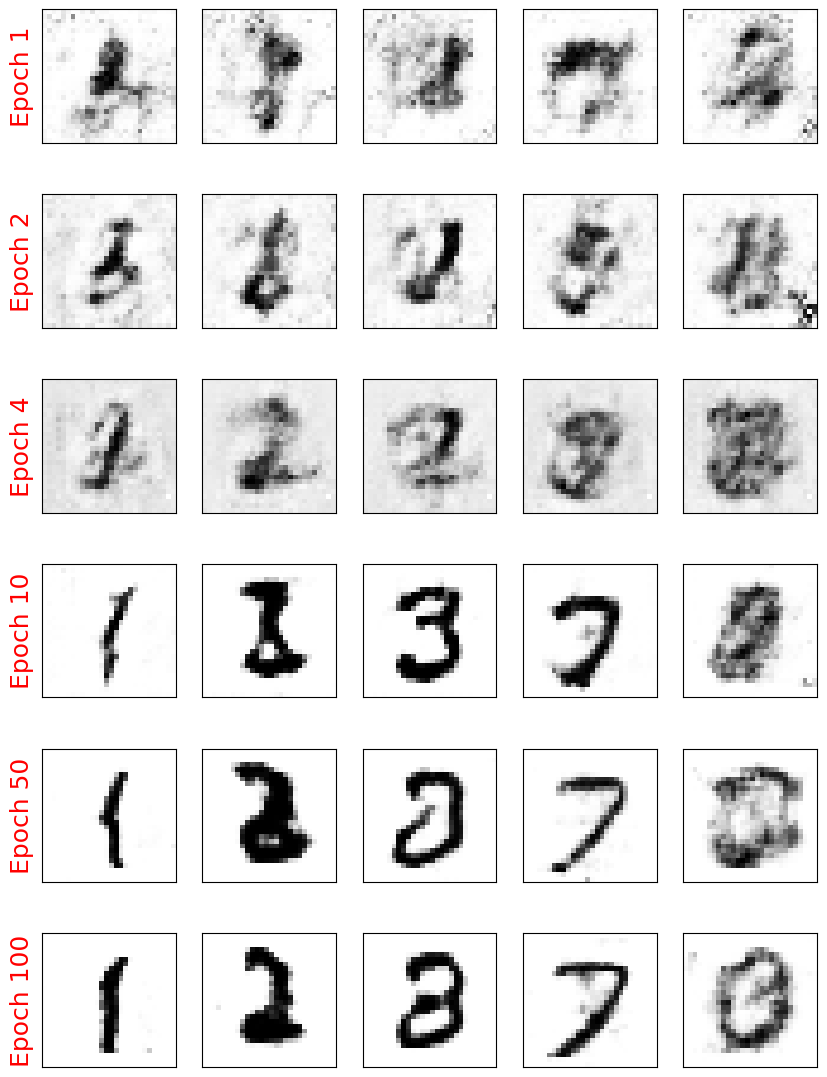

In [18]:
# selected_epochs = [1, 2, 3, 4, 5]
selected_epochs = [1, 2, 4, 10, 50, 100]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()